# Assignment 3

Run twice please.

<hr style="border:2px solid gray">

## Point 1

>Download **rrbsData.RData** file and read it into R using **load** function. Take a look at the **BsRaw** data object, including the assays, **rowRanges** and **colData** slots. 

>Filter the data to include only loci that have minimum 11x coverage in all samples and use this subset for all downstream analysis.

In [2]:
library(aods3)
library(limma)
library(BiSeq)

In [3]:
#data loading of rrbs
load("rrbsData.RData")
ls()
rrbs

[1] "rrbs"

class: BSraw 
dim: 963 4 
metadata(0):
assays(2): totalReads methReads
rownames: NULL
rowData names(0):
colnames(4): sample1 sample2 sample3 sample4
colData names(1): group

In [4]:
# Extract coverage information from the assays slot
coverage <- rrbs@assays$data$totalReads  # Assuming totalReads represent coverage info

# Check minimum coverage across all samples
min_coverage <- apply(coverage, 1, min)

# Filter the rows (loci) based on the coverage threshold (minimum 11x in all samples)
filtered_rows <- which(min_coverage >= 11)
rrbs_filtered <- rrbs[filtered_rows, ]

# Check dimensions of the filtered data
rrbs_filtered

class: BSraw 
dim: 854 4 
metadata(0):
assays(2): totalReads methReads
rownames: NULL
rowData names(0):
colnames(4): sample1 sample2 sample3 sample4
colData names(1): group

<hr style="border:1px solid gray">

## Point 2

>Compute the estimated methylation fraction for each locus and for each sample. Plot a histogram of the methylation fractions for each sample. Comment on the distribution.

png 
  2

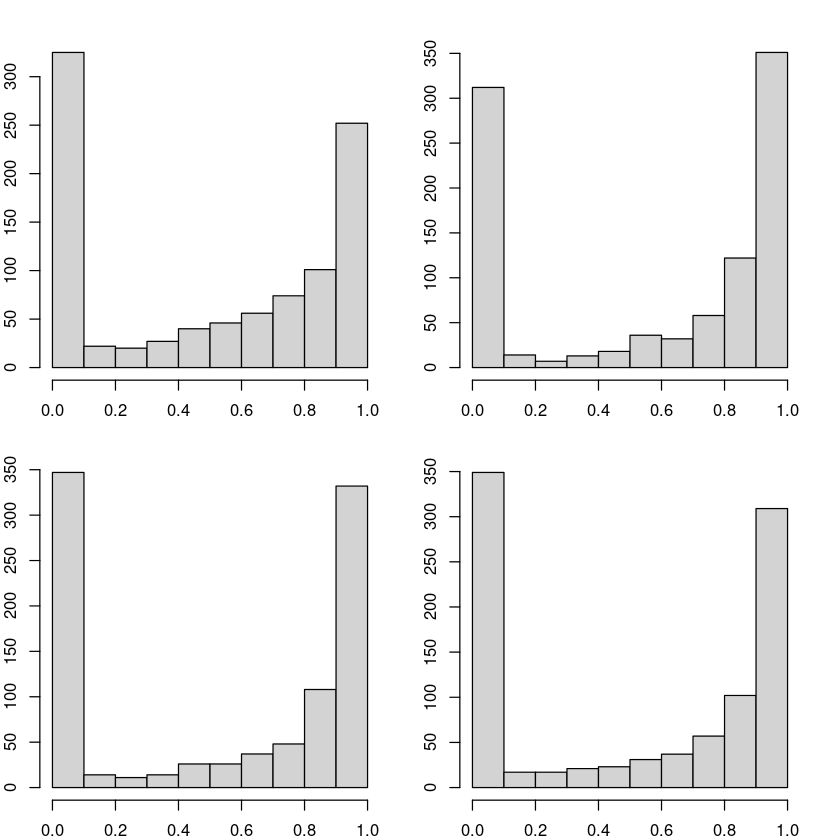

In [5]:

methylation_fractions <- rrbs@assays$data$methReads / rrbs@assays$data$totalReads

par(mar = c(2, 2, 2, 2))
par(mfrow = c(2, 2))

for (i in 1:ncol(methylation_fractions)) {
  hist(methylation_fractions[, i], main = colnames(methylation_fractions)[i], xlab = "Methylation Fraction")
}

pdf("meth-fractions.pdf")
par(mar = c(2, 2, 2, 2))
par(mfrow = c(2, 2))

for (i in 1:ncol(methylation_fractions)) {
  hist(methylation_fractions[, i], main = colnames(methylation_fractions)[i], xlab = "Methylation Fraction")
}

dev.off()

<hr style="border:1px solid gray">

## Point 3

> Compute the M-values for each locus and sample. M-value is calculated as
$$
M =\logit \left(\frac{y_\text{meth}+2}{y_\text{total}+2}\right)
$$
where $y_\text{meth}$ is the number of methylated reads and ytotal is the number of total reads. The above transformation adds pseudocounts to the read counts to avoid exact zeros and ones which would result to $\pm \infty$ in the logit transformation: +1 is added to both methylated and unmethylated reads (+2 added to total reads). Plot a histogram of M-values for each sample. Comment on the distribution (tasks 1, 2 and 3, 0.5 point altogether).

png 
  2

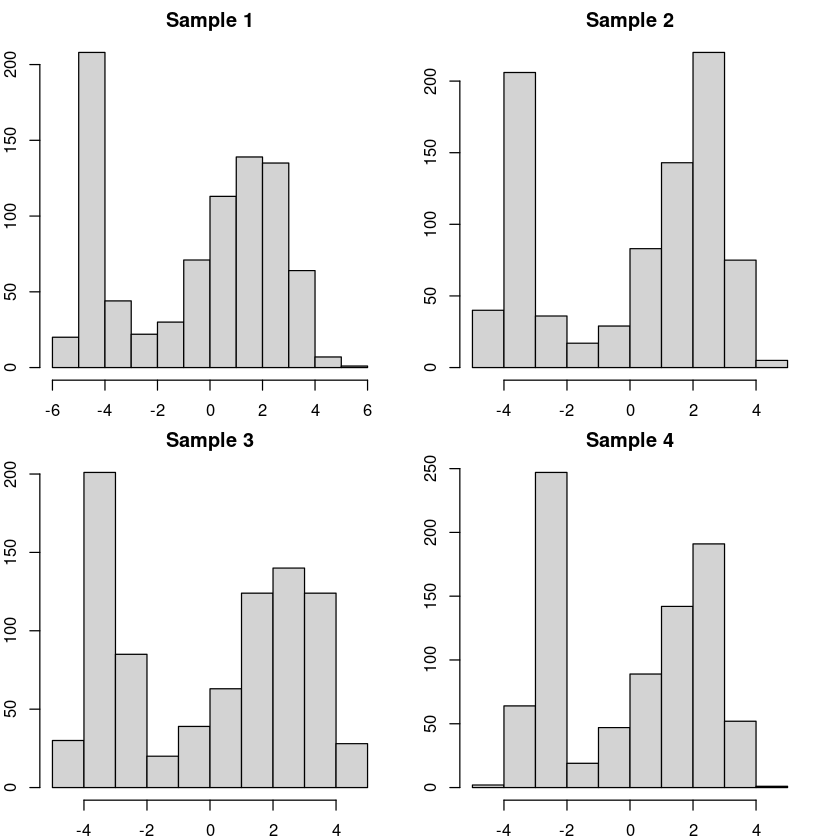

In [6]:

# Calculate M-values
y_meth <- rrbs_filtered@assays$data$methReads
y_total <- rrbs_filtered@assays$data$totalReads

pseudo_y_meth <- y_meth + 1
pseudo_y_total <- y_total + 2

# Compute M-values
M_values <- qlogis(pseudo_y_meth / pseudo_y_total)

# Plot histograms of M-values for each sample
par(mar = c(2, 2, 2, 2))
par(mfrow = c(2, 2))

for (i in 1:ncol(M_values)) {
  hist(M_values[, i], main = paste("Sample", i), xlab = "M-values")
}

# Save the plots to a PDF file
pdf("M-values_histograms.pdf")
par(mar = c(2, 2, 2, 2))
par(mfrow = c(2, 2))

for (i in 1:ncol(M_values)) {
  hist(M_values[, i], main = paste("Sample", i), xlab = "M-values")
}

dev.off()

<hr style="border:1px solid gray">

## Point 4

>Assume that the M-values can be approximated by a normal distribution and identify the differentially methylated loci (DML) between treatment and control groups using limma. limma implements the so-called moderated t-test that shares information between genes for more robust variance estimation. Use the information in the colData object to construct the design matrix, and check that the design matrix includes the intercept term. Adjust p-values for multiple testing using Benjamini-Hochberg procedure and count the number of loci with FDR < 0.05 (2 points).

I'll be utilizing the built-in function for Benjamin-Hochberg, as it has already been implemented in my previous exercise.

In [7]:
group <- colData(rrbs_filtered)$group

print(head(group))
print(head(M_values))

design_matrix <- model.matrix(~colData(rrbs_filtered)$group)
dim(design_matrix)
print(design_matrix)

fit <- lmFit(M_values, design_matrix)
print(summary(fit))

eb <- eBayes(fit)
print(summary(eb))

fdr <- p.adjust(eb$p.value, method = "BH")
print(summary(fdr))

num_sig_loci <- sum(fdr < 0.05)
print(paste("Number of loci with FDR < 0.05:", num_sig_loci))

[1] "treatment" "treatment" "control"   "control"  
          [,1]     [,2]      [,3]      [,4]
[1,] 0.3184537 1.405057 1.7346011 1.8274776
[2,] 0.7731899 1.127012 1.6094379 1.0881410
[3,] 2.9704145 2.577688 4.4308168 3.0204249
[4,] 0.4653632 1.876917 1.1526795 1.9169226
[5,] 1.1370786 2.574519 0.4054651 0.9343092
[6,] 1.7917595 3.601868 1.3350011 1.2039728


[1] 4 2

  (Intercept) colData(rrbs_filtered)$grouptreatment
1           1                                     1
2           1                                     1
3           1                                     0
4           1                                     0
attr(,"assign")
[1] 0 1
attr(,"contrasts")
attr(,"contrasts")$`colData(rrbs_filtered)$group`
[1] "contr.treatment"

                 Length Class  Mode     
coefficients     1708   -none- numeric  
rank                1   -none- numeric  
assign              2   -none- numeric  
qr                  5   qr     list     
df.residual       854   -none- numeric  
sigma             854   -none- numeric  
cov.coefficients    4   -none- numeric  
stdev.unscaled   1708   -none- numeric  
pivot               2   -none- numeric  
Amean             854   -none- numeric  
method              1   -none- character
design              8   -none- numeric  
                 Length Class  Mode     
coefficients     1708   -none- numeric  
rank     

In [8]:
unique_groups <- unique(colData(rrbs_filtered)$group)
print(unique_groups)

[1] "treatment" "control"  


<hr style="border:1px solid gray">

## Point 5

> Analyze the data using beta-binomial model. For this task you will use the aodml function from the aods3 package. Add pseudocounts to the methylated and total number of reads before learning the model. (Note that adding pseudocounts is not necessary for this model in general but numerical optimization can occasionally fail without these counts, if $y_\text{meth} = 0$ or $y_\text{meth} = y_\text{total}$ for all samples.) Learn 1) the full model and 2) the reduced model without the test factor. Note that the required data input to aodml function is a data frame. Check the template code for further help with the function (2 points).

### Guide Lines
    a. Pay attention to constructing the data frame
    b. The filtered data should be used
    c. See the code template for usage of aodml
    d. If you get warnings, they can be ignored


In [9]:
# Initializing vector for p-values
pvals <- c()

# For each locus i...
for (i in 1:nrow(rrbs_filtered)) {
  
  suppressWarnings({
    # Creating a data frame for individual locus i
    df <- data.frame(
      n = rrbs_filtered@assays$data$totalReads[i, ], # Get the total cytosine coverage
      m = rrbs_filtered@assays$data$methReads[i, ]   # Get the methylated cytosine count
    )
    
    # Adding the 'case' variable to the data frame
    df$case <- 0
    df$case[rrbs_filtered$group == 'treatment'] <- 1
    
    # Learn the full model
    fm <- aodml(cbind(m, n - m) ~ . , data = df, family = "bb",
                link = 'logit', phi.scale = 'log', method = 'BFGS')
    
    # Learn the reduced model
    rm <- aodml(cbind(m, n - m) ~ 1 , data = df, family = "bb",
                link = 'logit', phi.scale = 'log', method = 'Nelder-Mead')
    
    # Calculation of log-likelihood ratio and p-value 
    log_likelihood_diff <- 2 * (logLik(fm) - logLik(rm))
    
    # Calculation of p-value using the chi-squared distribution
    pvals[i] <- pchisq(log_likelihood_diff, 1, lower.tail = FALSE)
  })
}

In [10]:
 # Cp-values
fdr2 <- p.adjust(pvals, method = "BH")
cat(head(fdr2,5))

0.1445552 1 0.2605618 0.8541684 0.2932088

<hr style="border:1px solid gray">

## Point 6

>Compare the full and reduced models by computing the log-likelihood ratios and test for significance using the chi-squared test. Correct the p-values for multiple testing and count the loci with FDR< 0.05 (0.25 point).

Pay attention on computing the log-likelihood ratio test and the degrees of
freedom

In [11]:
# Count the loci with FDR < 0.05
num_sig_loci <- sum(fdr2 < 0.05)
cat('Num loci with FDR < 0.05',num_sig_loci)

Num loci with FDR < 0.05 25

<hr style="border:1px solid gray">

## Point 7

>Compare the DML obtained with limma and aodml. How many DML
do you get from each method? How many DML are unique to each
method? Comment on the possible sources of differences between the
two methods (0.25 point).

    1. When determining the unique DML for each method, report the number of indexes of DMLs uniquely identified by the methods. Do not report number of DMLs based on unique fdr or p-values.
    2. Possibly useful functions which() and %in%



In [13]:
limma_DML_indexes <- which(fdr < 0.05)  # fdr with the limma results

aodml_DML_indexes <- which(fdr2 < 0.05)  # fdr2 with the aodml results

# Find DMLs unique to limma
limma_unique_indexes <- limma_DML_indexes[!(limma_DML_indexes %in% aodml_DML_indexes)]

# Find DMLs unique to aodml
aodml_unique_indexes <- aodml_DML_indexes[!(aodml_DML_indexes %in% limma_DML_indexes)]

# Get the total number of DMLs identified by each method
num_limma_DMLs <- length(limma_DML_indexes)
num_aodml_DMLs <- length(aodml_DML_indexes)

# Get the number of DMLs unique to each method
num_limma_unique <- length(limma_unique_indexes)
num_aodml_unique <- length(aodml_unique_indexes)

# Print the results
cat("Total DMLs identified by limma:", num_limma_DMLs, "\n")
cat("Total DMLs identified by aodml:", num_aodml_DMLs, "\n")
cat("DMLs unique to limma (Indexes):", limma_unique_indexes, "\n")
cat("DMLs unique to aodml (Indexes):", aodml_unique_indexes, "\n")
cat("Number of DMLs unique to limma:", num_limma_unique, "\n")
cat("Number of DMLs unique to aodml:", num_aodml_unique, "\n")

Total DMLs identified by limma: 807 
Total DMLs identified by aodml: 25 
DMLs unique to limma (Indexes): 1 2 3 4 8 9 10 14 15 17 20 21 22 23 24 26 27 28 29 32 39 41 45 53 55 57 58 60 61 62 64 68 69 73 75 76 77 78 79 80 81 82 83 85 87 88 89 94 95 96 98 100 101 102 103 104 105 106 108 109 110 115 116 118 119 120 121 123 125 126 128 129 132 134 136 138 139 141 142 144 145 146 147 148 149 150 151 152 153 154 156 157 158 160 161 162 163 164 165 166 167 168 169 170 172 173 175 177 178 179 180 182 183 184 187 188 190 192 193 194 195 196 197 200 201 203 206 207 209 210 211 213 214 215 217 218 224 225 226 227 229 230 231 232 233 234 235 236 239 240 241 242 243 245 246 247 248 249 250 251 253 254 255 256 259 260 261 262 263 264 267 275 285 295 296 306 307 309 316 317 318 319 320 321 322 323 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 356 357 358 359 360 361 362 363 365 366 367 368 369 370 371 372 373 374 375 376 377 378 